# Приближенное решение смешанной краевой задачи для неоднородного уравнения теплопроводности

## Вариант 3

> <span style="font-style:normal; font-size:12pt;"> 
        <ol> 
            <li>Найти численное решение смешанной краевой задачи для неоднородного уравнения теплопроводности при x на отрезке [0,1]. Для расчета решения использовать схему с весами с шагом h = 0.05 по переменной x. Предусмотреть возможность произвольного задания шага по переменной t и времени окончания расчета (по умолчанию τ = 0.05 и T = 1, соответственно). </li>
            <li>Для получения решения использовать начальные и граничные условия первого и
                второго порядка точности.</li>
        </ol> 
    <p>  Для сравнения приведено точное решение u0(x,t). </p>
    
$$
\begin{cases}
u_{t} = u_{xx} + \frac{2x(1+x+xt)+(1+t)^{2}}{4(1+x+xt)^{3/2}}, \\
u(0,t) + 2u_x(0,t) = 2 + t,                                    \\
u(1,t) + 2u_x(1,t) = \frac{3+2t}{\sqrt{2+t}},                  \\ 
u(x,0) = \sqrt{1+x},                                           \\ 
\end{cases}
$$

$$
\begin{equation}
u_{0}(x,t) = \sqrt{1+x+xt}
\end{equation}
$$

In [1]:
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from matplotlib           import cm

In [2]:
# Метод прогонки для решения СЛАУ
def Thomas_algorithm(a_plot, b_plot, c_plot, f_plot):
    n = len(f_plot)
    y_plot = []
        
    A_plot = []
    B_plot = []
    
    A0 = (-1) * c_plot[0] / b_plot[0]
    B0 = f_plot[0] / b_plot[0]
    
    A_plot.append(A0)
    B_plot.append(B0)
    
    for i in range(1, n - 1):
        Ai = (-1) * c_plot[i] / (b_plot[i] + a_plot[i] * A_plot[i - 1])
        A_plot.append(Ai)
    
    for i in range(1, n):
        Bi = (f_plot[i] - a_plot[i] * B_plot[i - 1]) / (b_plot[i] + a_plot[i] * A_plot[i - 1])
        B_plot.append(Bi)
    
    An = 0   
    A_plot.append(An)    
    
    y_plot.append(B_plot[n - 1])
    
    for i in range(n - 2, -1, -1):
        yi = B_plot[i] + A_plot[i] * y_plot[0]
        y_plot.insert(0, yi)
    
    return y_plot

In [3]:
# Вычисление констант СЛАУ (апроксимация)
def SLE_constants(x_plot, t, t_i, prev_layer,
                  sigma, a, f,
                  alpha_1, beta_1, gamma_1, 
                  alpha_2, beta_2, gamma_2,
                  precision=1):
    
    if precision != 1 and precision != 2:
        return
    
    m = len(x_plot)
   
    h = x_plot[1] - x_plot[0]
    
    a_plot = []
    b_plot = []
    c_plot = []
    f_plot = []
    
    c  = a**2 * t / h**2
    
    if precision == 1:
        a0 = 0
        b0 = beta_1(t_i)  - alpha_1(t_i) / h
        c0 = alpha_1(t_i) / h
        f0 = gamma_1(t_i)

        am = (-1) * alpha_2(t_i) / h
        bm = alpha_2(t_i) / h + beta_2(t_i)
        cm = 0
        fm = gamma_2(t_i)
    
    elif precision == 2:
        
        if alpha_1(t_i) != 0 and alpha_2(t_i) != 0:
            a0 = 0
            b0 = 1 - 2 * c * sigma * (h * beta_1(t_i) / alpha_1(t_i) - 1)
            c0 = -2 * c * sigma
            f0 = ( prev_layer[0] * (1 + 2 * c *(1 - sigma) * (h * beta_1(t_i) / alpha_1(t_i) - 1)) +
                  2 * c * (1 - sigma) * prev_layer[1] -
                  2 * c * h * gamma_1(t_i) / alpha_1(t_i) +
                  t * f(x_plot[0], t_i - t / 2)
                  )
            

            am = -2 * c * sigma
            bm = 1 + 2 * c * sigma * (h * beta_2(t_i) / alpha_2(t_i) + 1)
            cm = 0
            fm = ( prev_layer[m - 2] * 2 * c * (1 - sigma) +
                   prev_layer[m - 1] * (1 - 2 * c * (1 - sigma) * (h * beta_2(t_i) / alpha_2(t_i) + 1)) +
                  2 * c * h * gamma_2(t_i) / alpha_2(t_i) + 
                  f(x_plot[m - 1], t_i - t / 2) * t
                 )
            
    a_plot.append(a0)
    b_plot.append(b0)
    c_plot.append(c0)
    f_plot.append(f0)

    for k in range(1, m - 1):
        ak = c * sigma
        bk = (-2) * c * sigma - 1
        ck = c * sigma
        fk = ((-1) * prev_layer[k] - f(x_plot[k], t_i - t / 2) * t + 
              (sigma - 1) * c * (prev_layer[k + 1] - 2 * prev_layer[k] + prev_layer[k - 1]))

        a_plot.append(ak)
        b_plot.append(bk)
        c_plot.append(ck)
        f_plot.append(fk)

    a_plot.append(am)
    b_plot.append(bm)
    c_plot.append(cm)
    f_plot.append(fm)
    
    return a_plot, b_plot, c_plot, f_plot

In [4]:
def decision_fig(X, Y, Z0, Z, precision=1):
    fig = plt.figure(figsize=(8, 8))
    ax  = fig.add_subplot(111, projection='3d')

    ax.plot_wireframe(X, Y, Z0,  rstride=10, cstride=10, label='analytical solution')
    
    if precision == 1:
        ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, color='orange', label='precision_1')
    if precision == 2:
        ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, color='orange', label='precision_2')
        
    ax.set_xlabel('x', fontsize=10)        
    ax.set_ylabel('t', fontsize=10)
    ax.set_zlabel('u', fontsize=10)

    plt.title('Численное решение', fontsize=10)
    plt.legend(fontsize=8)

    plt.show()
    
    print("h = ", X[0][1] - X[0][0], "t = ", Y[1][0] - Y[0][0])

In [5]:
def error_fig(X, Y, errors, precision=1):
    fig = plt.figure(figsize=(8, 8))
    ax  = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, errors, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_xlabel('x', fontsize=10)        
    ax.set_ylabel('t', fontsize=10)
    ax.set_zlabel('error', fontsize=10)

    if precision == 1:
        plt.title('Ошибка первого порядка', fontsize=10)
    if precision == 2:
        plt.title('Ошибка второго порядка', fontsize=10)
    
    plt.show()
    
    print("h = ", X[0][1] - X[0][0], "t = ", Y[1][0] - Y[0][0])

## Постановка задачи

In [6]:
# неоднородность
def f(x, t):
    return 1/4 * (2 * x * (1 + x + x * t) + (1 + t)**2) / (1 + x + x * t)**(3/2)

# начальное условие
def phi(x):
    return (1 + x)**(1/2)

# граничные условия
def gamma_1(t):
    return 2 + t

def gamma_2(t):
    return (3 + 2 * t) / (2 + t)**(1/2)


# Параметры
def alpha_1(t):
    return 2

def beta_1(t):
    return 1

def alpha_2(t):
    return 2

def beta_2(t):
    return 1

# точное решение для анализа
def u(x, t):
    return (1 + x + x * t)**(1/2)


# Область значений и шаг по x
left  = 0
right = 1
h     = 0.05 

# Область значений и шаг по t
t0 = 0
T  = 1
t  =  0.05

# параметр веса
sigma = 1 / 2

# коэффициент волнового уравнения
a = 1

In [7]:
x_plot = np.linspace(left, right, round((right - left) / h) + 1)       # координатная сетка
t_plot = np.linspace(t0,   T,     round((T - t0) / t) + 1)             # временная сетка (слои)

## Численное решение

### 1. Первый порядок точности

In [8]:
u_plot1 = []

In [9]:
layer_0 = [phi(x) for x in x_plot]

u_plot1.append(layer_0)

In [10]:
layer_i = layer_0

for t_i in t_plot[1:]:
    a1_plot, b1_plot, c1_plot, d1_plot = SLE_constants(x_plot, t, t_i, layer_i,
                                                       sigma, a, f,
                                                       alpha_1, beta_1, gamma_1, 
                                                       alpha_2, beta_2, gamma_2)
    layer_i = Thomas_algorithm(a1_plot, b1_plot, c1_plot, d1_plot)

    u_plot1.append(layer_i)

In [11]:
X, Y = np.meshgrid(x_plot, t_plot)
Z0   = u(X, Y)
Z    = np.asarray(u_plot1)

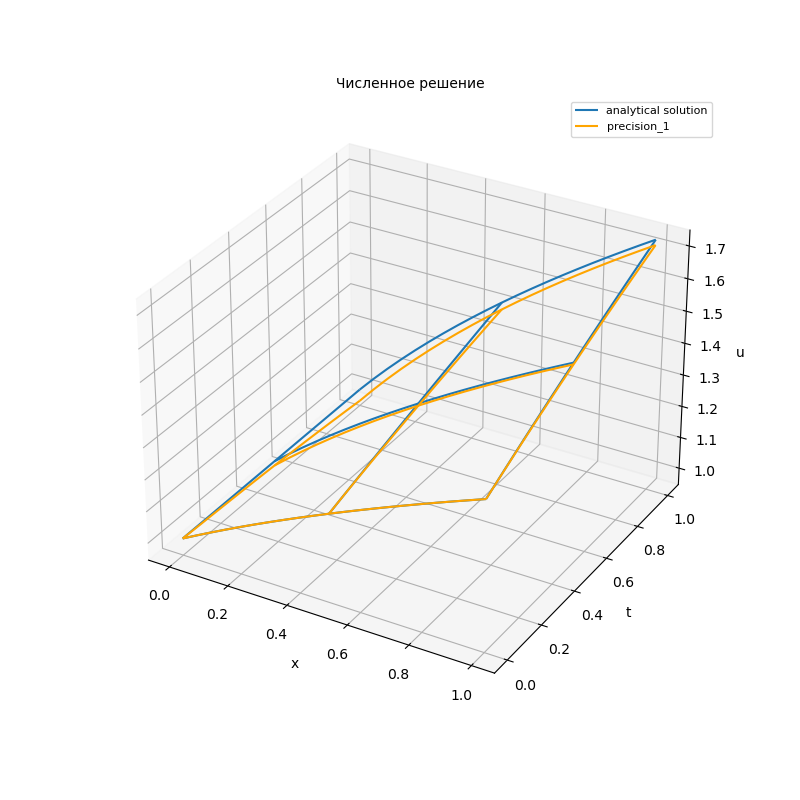

h =  0.05 t =  0.05


In [12]:
decision_fig(X, Y, Z0, Z, precision=1)

#### Погрешность

In [13]:
errors = []

for n in range(len(Z0)):
    errors_i = [abs(z0 - z) for z0, z in zip(Z0[n], Z[n])]
    errors.append(errors_i)
    
errors = np.array(errors)

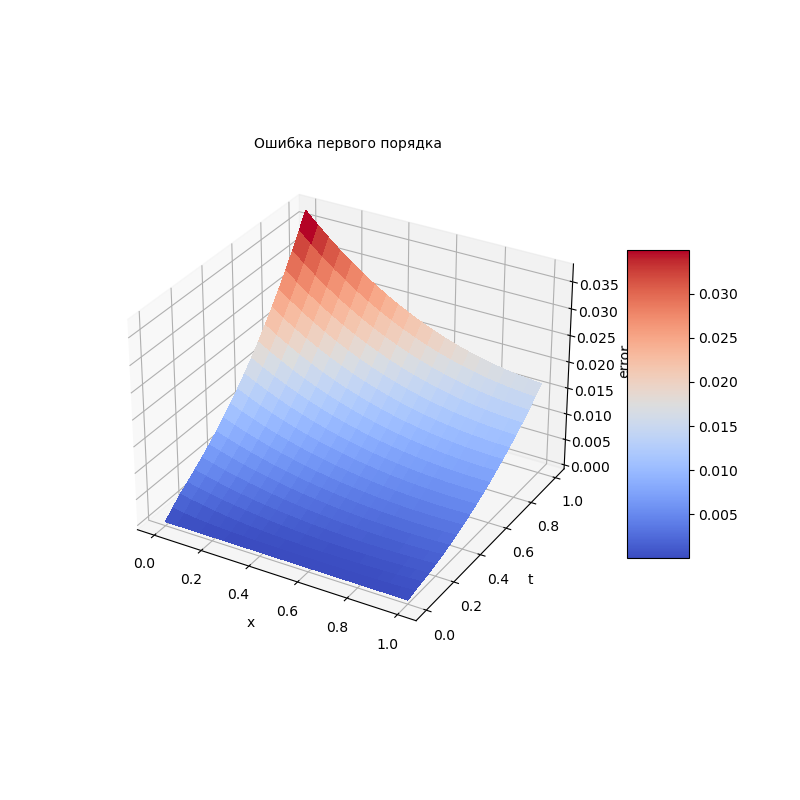

h =  0.05 t =  0.05


In [14]:
error_fig(X, Y, errors, precision=1)

<span style="font-style:italic; font-size:14pt;"> 
    <p>
        Максимальная ошибка:
    </p>


In [15]:
np.max(errors)

0.037494402015462835

### 2. Второй порядок точности

In [16]:
u_plot2 = []

In [17]:
layer_0 = [phi(x) for x in x_plot]

u_plot2.append(layer_0)

In [18]:
layer_i = layer_0

for t_i in t_plot[1:]:
    a2_plot, b2_plot, c2_plot, d2_plot = SLE_constants(x_plot, t, t_i, layer_i,
                                                       sigma, a, f,
                                                       alpha_1, beta_1, gamma_1, 
                                                       alpha_2, beta_2, gamma_2,
                                                       precision=2)
    layer_i = Thomas_algorithm(a2_plot, b2_plot, c2_plot, d2_plot)
    
    
    u_plot2.append(layer_i)

In [19]:
X, Y = np.meshgrid(x_plot, t_plot)
Z0   = u(X, Y)
Z    = np.asarray(u_plot2)

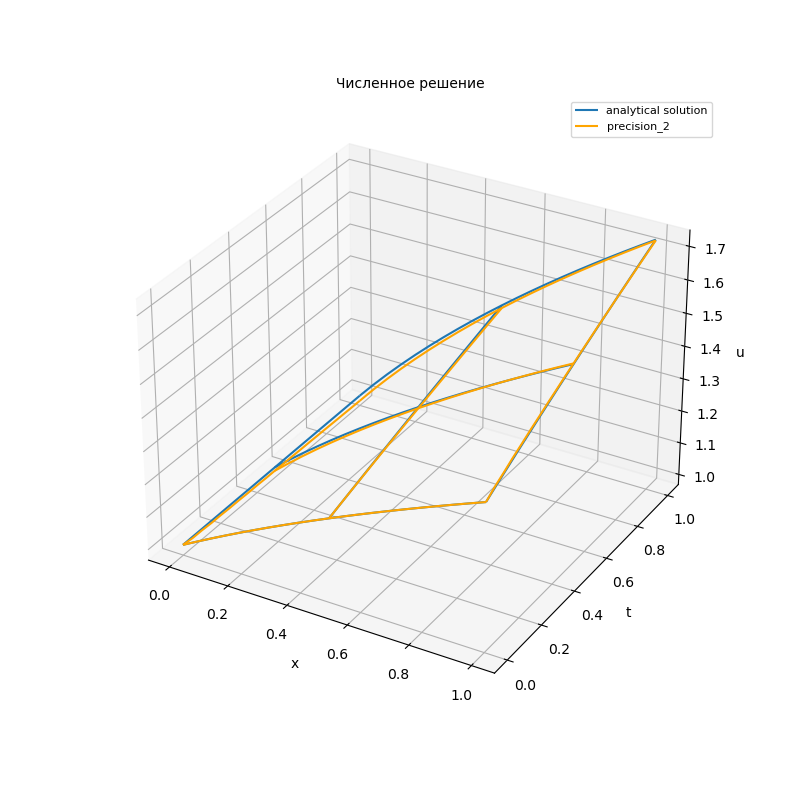

h =  0.05 t =  0.05


In [20]:
decision_fig(X, Y, Z0, Z, precision=2)

#### Погрешность

In [21]:
errors = []

for n in range(len(Z0)):
    errors_i = [abs(z0 - z) for z0, z in zip(Z0[n], Z[n])]
    errors.append(errors_i)
    
errors = np.array(errors)

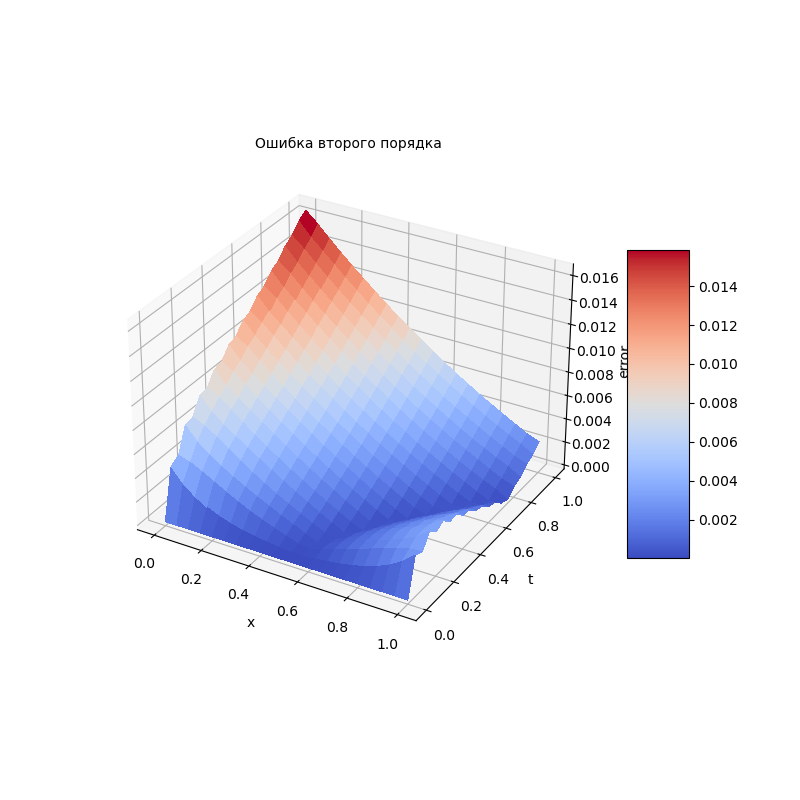

h =  0.05 t =  0.05


In [22]:
error_fig(X, Y, errors, precision=2)

<span style="font-style:italic; font-size:14pt;"> 
    <p>
        Максимальная ошибка:
    </p>


In [23]:
np.max(errors)

0.016590742964624705